In [1]:
%pip install -r requirements.txt

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import plotly.express as px
import plotly.graph_objects as go

In [2]:
directory = '../java/resources/results/'
all_cases_cloudlets = {}
all_cases_vms = {}
all_cases_brokers = {}

for filename in os.listdir(directory):
    
    base= os.path.basename(filename)
    name = os.path.splitext(base)[0]
    # print(i)
    
    aux_df = pd.read_csv(directory+filename+'/cloudlets_results.csv')
    aux_df.rename(columns={'Cloudlet ID':'task', 'Start Time':'start_time', 'Finish Time':'finish_time', 'Execution Time':'duration', 'VM ID':'vm'}, inplace=True)
    all_cases_cloudlets[name] = aux_df
    aux_vms = pd.read_csv(directory+filename+'/vms_results.csv')
    aux_vms.rename(columns={'VM ID':'vm', 'VM Load':'vm_load', 'Total Execution Time':'duration'}, inplace=True)
    all_cases_vms[name] = aux_vms
    aux_brokers = pd.read_csv(directory+filename+'/brokers_results.csv')
    aux_brokers.rename(columns={'Cpu Utilization':'utilization'}, inplace=True)
    all_cases_brokers[name] = aux_brokers
    
all_cases_cloudlets.keys()

dict_keys(['scenario-1-100', 'scenario-1-150', 'scenario-1-200', 'scenario-1-25', 'scenario-1-50', 'scenario-15-100', 'scenario-15-150', 'scenario-15-200', 'scenario-15-25', 'scenario-15-50', 'scenario-3-100', 'scenario-3-150', 'scenario-3-200', 'scenario-3-25', 'scenario-3-50', 'scenario-6-100', 'scenario-6-150', 'scenario-6-200', 'scenario-6-25', 'scenario-6-50', 'scenario-9-100', 'scenario-9-150', 'scenario-9-200', 'scenario-9-25', 'scenario-9-50'])

In [3]:
scenario = 'scenario-15-200'
current_case = all_cases_cloudlets[scenario]
current_case_vms = all_cases_vms[scenario]
scenario

'scenario-15-200'

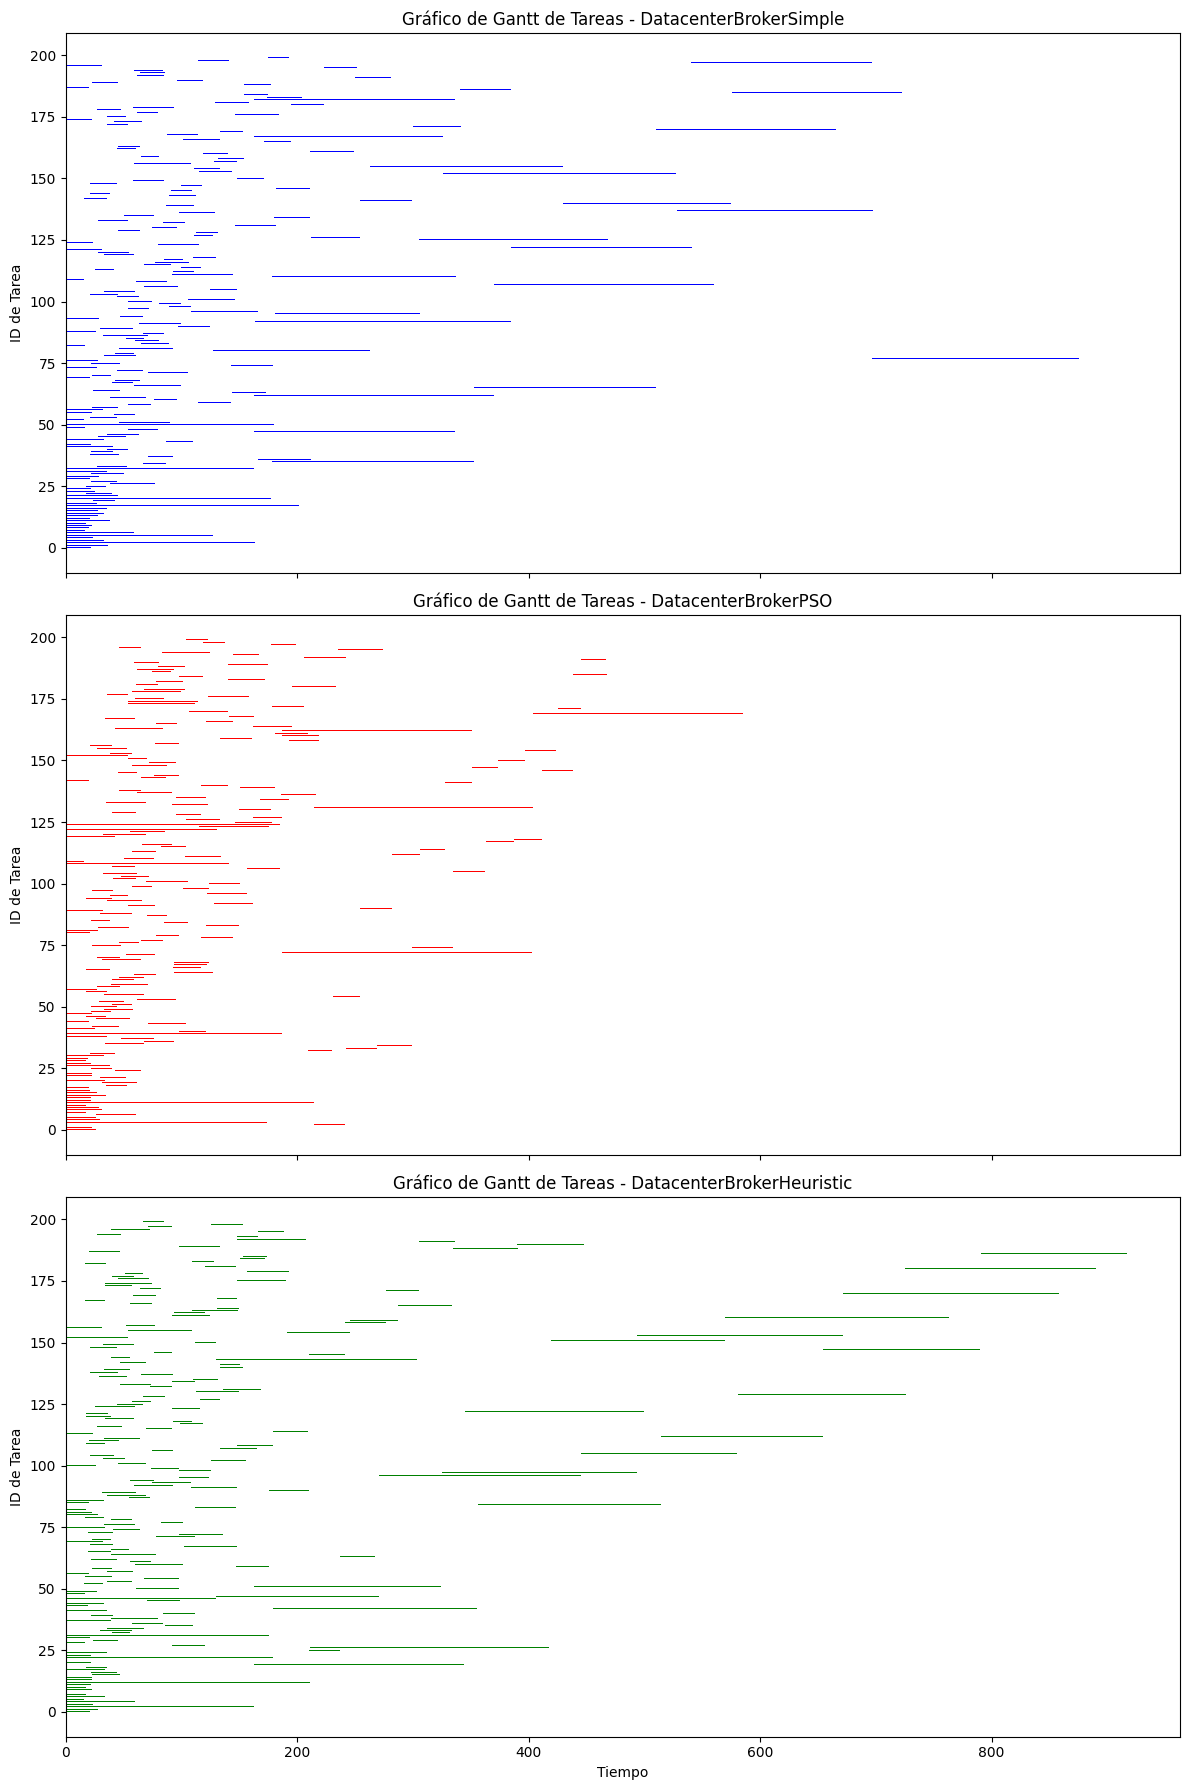

In [5]:
# Filtrar los datos por cada broker
brokers = current_case['Broker'].unique()
num_brokers = len(brokers)

# Crear subplots
fig, axs = plt.subplots(num_brokers, 1, figsize=(12, 6 * num_brokers), sharex=True)

# Si solo hay un broker, axs no será una lista, así que lo convertimos en una lista
if num_brokers == 1:
    axs = [axs]

# Crear un gráfico para cada broker
for ax, broker in zip(axs, brokers):
    broker_data = current_case[current_case['Broker'] == broker]
    for i, task in broker_data.iterrows():
        color_map = {
            'DatacenterBrokerSimple': 'blue',
            'DatacenterBrokerPSO': 'red',
            'DatacenterBrokerHeuristic': 'green'
        }
        ax.barh(y=task['task'], width=task['duration'], left=task['start_time'], height=0.4, color=color_map.get(task['Broker'], 'gray'))
    ax.set_ylabel('ID de Tarea')
    ax.set_title(f'Gráfico de Gantt de Tareas - {broker}')

# Configurar el eje x compartido
axs[-1].set_xlabel('Tiempo')

plt.tight_layout()
plt.show()

In [6]:
all_cases_brokers['scenario-15-200']['Maskespan']

0    876.08
1    585.00
2    916.38
Name: Maskespan, dtype: float64

In [15]:
# speedup (mejor maquina vs tiempo)
speedups = {}
for scenario in all_cases_brokers.keys():
    current_case = all_cases_brokers[scenario]
    vms = scenario.split('-')[1]
    if vms == '1':
        continue
    cloudlets = scenario.split('-')[2]
    secuential_times = all_cases_brokers[f'scenario-1-{cloudlets}']
    if(cloudlets not in speedups):
        speedups[cloudlets] = {}
    if(vms not in speedups[cloudlets]):
        speedups[cloudlets][vms] = {}

    for broker in current_case['Broker'].unique():
        if broker == 'DatacenterBrokerSimple':
            new_name = 'Simple'
        elif broker == 'DatacenterBrokerPSO':
            new_name = 'PSO'
        else:
            new_name = 'Heuristic'
        broker_data = current_case[current_case['Broker'] == broker]
        speedups[cloudlets][vms][new_name] = float(secuential_times[secuential_times['Broker'] == broker]['Maskespan'].values[0]) / float(broker_data['Maskespan'].values[0])
    speedups[cloudlets] = dict(sorted(speedups[cloudlets].items(), key=lambda item: int(item[0])))
speedups = dict(sorted(speedups.items(), key=lambda item: int(item[0])))


In [16]:
speedups

{'25': {'3': {'Simple': 0.6986885538406636,
   'PSO': 2.352538299789727,
   'Heuristic': 0.6430518606102407},
  '6': {'Simple': 1.029552505652837,
   'PSO': 1.9006892534705366,
   'Heuristic': 1.1571854960252963},
  '9': {'Simple': 1.0840485022977686,
   'PSO': 2.355651807736269,
   'Heuristic': 1.9293456838785965},
  '15': {'Simple': 2.0532746054218447,
   'PSO': 6.622357517334685,
   'Heuristic': 1.8447260564375558}},
 '50': {'3': {'Simple': 0.9077751781925023,
   'PSO': 2.32847652542846,
   'Heuristic': 0.7828086144606577},
  '6': {'Simple': 1.4961618480522278,
   'PSO': 2.794827124095417,
   'Heuristic': 1.98969613127892},
  '9': {'Simple': 2.0284991732321758,
   'PSO': 3.8955823293172696,
   'Heuristic': 2.678439556911222},
  '15': {'Simple': 2.583782444403147,
   'PSO': 4.212705787294213,
   'Heuristic': 4.017143407493018}},
 '100': {'3': {'Simple': 0.7896220762267543,
   'PSO': 1.9076750077551445,
   'Heuristic': 0.7413678785626024},
  '6': {'Simple': 1.4913505648404504,
   'PSO

In [17]:
# import plotly.graph_objects as go

# Supongamos que 'speedups' es un diccionario con la estructura {cloudlets: {broker: speedup}}
scenario_selected = speedups['200']
# Crear el gráfico
fig = go.Figure()

# Agregar las barras para cada broker en cada escenario
for scenario, data in scenario_selected.items():
    for i, (broker, speedup) in enumerate(data.items()):
        fig.add_trace(go.Bar(
            x=[scenario],
            y=[speedup],
            name=broker,
            text=f'{broker}: {float(speedup):.2f}',  # Agregar información al tooltip
            hoverinfo='text',
            offsetgroup=i  # Asegurar que las barras estén centradas
        ))

# Configurar el layout del gráfico
fig.update_layout(
    barmode='group',
    xaxis_title='200 Cloudlets',
    yaxis_title='Speedup',
    title='Speedup de cada broker en función del escenario',
    xaxis={'type': 'category'},  # Asegurar que el eje x sea categórico
    bargap=0.05,  # Reducir la separación entre barras dentro de un grupo
    bargroupgap=0.1  # Reducir la separación entre grupos de barras
)

# Mostrar el gráfico
fig.show()

In [18]:
# escalado de vm, fijo tareas 
# escalado de tareas, fijo vm
tiempos = {}
for scenario in all_cases_brokers.keys():
    current_case = all_cases_brokers[scenario]
    vms = scenario.split('-')[1]
    cloudlets = scenario.split('-')[2]
    if(cloudlets not in tiempos):
        tiempos[cloudlets] = {}
    if(vms not in tiempos[cloudlets]):
        tiempos[cloudlets][vms] = {}

    for broker in current_case['Broker'].unique():
        if broker == 'DatacenterBrokerSimple':
            new_name = 'Simple'
        elif broker == 'DatacenterBrokerPSO':
            new_name = 'PSO'
        else:
            new_name = 'Heuristic'
        broker_data = current_case[current_case['Broker'] == broker]
        tiempos[cloudlets][vms][new_name] = float(broker_data['Maskespan'].values[0])
    tiempos[cloudlets] = dict(sorted(tiempos[cloudlets].items(), key=lambda item: int(item[0])))
tiempos = dict(sorted(tiempos.items(), key=lambda item: int(item[0])))
tiempos

{'25': {'1': {'Simple': 391.58, 'PSO': 391.58, 'Heuristic': 391.58},
  '3': {'Simple': 560.45, 'PSO': 166.45, 'Heuristic': 608.94},
  '6': {'Simple': 380.34, 'PSO': 206.02, 'Heuristic': 338.39},
  '9': {'Simple': 361.22, 'PSO': 166.23, 'Heuristic': 202.96},
  '15': {'Simple': 190.71, 'PSO': 59.13, 'Heuristic': 212.27}},
 '50': {'1': {'Simple': 834.2, 'PSO': 834.2, 'Heuristic': 834.2},
  '3': {'Simple': 918.95, 'PSO': 358.26, 'Heuristic': 1065.65},
  '6': {'Simple': 557.56, 'PSO': 298.48, 'Heuristic': 419.26},
  '9': {'Simple': 411.24, 'PSO': 214.14, 'Heuristic': 311.45},
  '15': {'Simple': 322.86, 'PSO': 198.02, 'Heuristic': 207.66}},
 '100': {'1': {'Simple': 1475.93, 'PSO': 1475.93, 'Heuristic': 1475.93},
  '3': {'Simple': 1869.16, 'PSO': 773.68, 'Heuristic': 1990.82},
  '6': {'Simple': 989.66, 'PSO': 586.28, 'Heuristic': 946.57},
  '9': {'Simple': 807.83, 'PSO': 407.51, 'Heuristic': 741.84},
  '15': {'Simple': 552.88, 'PSO': 307.11, 'Heuristic': 432.71}},
 '150': {'1': {'Simple': 225

In [19]:

scenario_selected = tiempos['200']
# Crear el gráfico
fig = go.Figure()

# Agregar las barras para cada broker en cada escenario
for scenario, data in scenario_selected.items():
    for i, (broker, tiempo) in enumerate(data.items()):
        fig.add_trace(go.Bar(
            x=[scenario],
            y=[tiempo],
            name=broker,
            text=f'{broker}: {float(tiempo):.2f}',  # Agregar información al tooltip
            hoverinfo='text',
            offsetgroup=i  # Asegurar que las barras estén centradas
        ))

# Configurar el layout del gráfico
fig.update_layout(
    barmode='group',
    xaxis_title='200 Cloudlets',
    yaxis_title='tiempos',
    title='Tiempos de cada broker en función de las VMs',
    xaxis={'type': 'category'},  # Asegurar que el eje x sea categórico
    bargap=0.05,  # Reducir la separación entre barras dentro de un grupo
    bargroupgap=0.1  # Reducir la separación entre grupos de barras
)

# Mostrar el gráfico
fig.show()

In [25]:
tiempos_vms

{'25': {'Simple': 190.71, 'PSO': 59.13, 'Heuristic': 212.27},
 '50': {'Simple': 322.86, 'PSO': 198.02, 'Heuristic': 207.66},
 '100': {'Simple': 552.88, 'PSO': 307.11, 'Heuristic': 432.71},
 '150': {'Simple': 726.12, 'PSO': 383.11, 'Heuristic': 568.61},
 '200': {'Simple': 876.08, 'PSO': 585.0, 'Heuristic': 916.38}}

In [24]:
# obtenemos los tiempos de ejecucion de cada broker en los cuales se ejecutaron con 15 vms
tiempos_vms = {}
for scenario in all_cases_brokers.keys():
    current_case = all_cases_brokers[scenario]
    vms = scenario.split('-')[1]
    cloudlets = scenario.split('-')[2]
    if(vms != '15'):
        continue
    if(cloudlets not in tiempos_vms):
        tiempos_vms[cloudlets] = {}
    if(vms not in tiempos_vms[cloudlets]):
        tiempos_vms[cloudlets] = {}

    for broker in current_case['Broker'].unique():
        if broker == 'DatacenterBrokerSimple':
            new_name = 'Simple'
        elif broker == 'DatacenterBrokerPSO':
            new_name = 'PSO'
        else:
            new_name = 'Heuristic'
        broker_data = current_case[current_case['Broker'] == broker]
        tiempos_vms[cloudlets][new_name] = float(broker_data['Maskespan'].values[0])
tiempos_vms = dict(sorted(tiempos_vms.items(), key=lambda item: int(item[0])))
# Crear el gráfico
fig = go.Figure()

# Agregar las barras para cada broker en cada escenario
for scenario, data in tiempos_vms.items():
    for i, (broker, tiempo) in enumerate(data.items()):
        fig.add_trace(go.Bar(
            x=[scenario],
            y=[tiempo],
            name=broker,
            text=f'{broker}: {float(tiempo):.2f}',  # Agregar información al tooltip
            hoverinfo='text',
            offsetgroup=i  # Asegurar que las barras estén centradas
        ))

# Configurar el layout del gráfico
fig.update_layout(
    barmode='group',
    xaxis_title='15 Vms',
    yaxis_title='tiempos',
    title='Tiempos de cada broker en función de las tareas',
    xaxis={'type': 'category'},  # Asegurar que el eje x sea categórico
    bargap=0.05,  # Reducir la separación entre barras dentro de un grupo
    bargroupgap=0.1  # Reducir la separación entre grupos de barras
)

# Mostrar el gráfico
fig.show()

In [ ]:
# Cargar y pivotear los datos
df_pivot = current_case_vms.pivot(index='Broker', columns='vm', values='vm_load').fillna(0)

task_counts = current_case.groupby(['Broker', 'vm']).size()
vm_color = 'blue'

# Crear el gráfico
fig = go.Figure()

for vm in df_pivot.columns:
    hover_data = []
    for broker in df_pivot.index:
        task_count = int(task_counts[broker][vm])
        task_count = task_count if task_count >= 0 else 0
        hover_data.append(f'VM {vm} (Tareas: {task_count})')
    fig.add_trace(go.Bar(
        x=df_pivot.index,
        y=df_pivot[vm],
        name=f'VM {vm}',
        hovertext=hover_data,
    ))

fig.update_layout(
    barmode='stack',
    xaxis_title='Algoritmo',
    yaxis_title='Utilización de CPU (%)',
    title='Utilización de CPU por VM por cada algoritmo'
)
fig.show()